<h1>군집화 실습 - 고객 세그먼테이션</h1><br>



<img src="./img/Customer_Segmentation.png"/>

### 데이터 셋 로딩과 데이터 클린징

[UCI Online Retail 데이터 바로가기](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II)<br>

이 데이터는 상품 주문 데이터다. <br>




<b>Attribute Information:</b><br>

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.　C가 있으면 주문 취소 데이터 <br><br>
StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.<br><br>
Description: Product (item) name. Nominal.<br><br>
Quantity: The quantities of each product (item) per transaction. Numeric.<br><br>
InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.<br><br>
UnitPrice: Unit price. Numeric, Product price per unit in sterling.<br><br>
CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.<br><br>
Country: Country name. Nominal, the name of the country where each customer resides.<br><br>


In [1]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df = pd.read_excel(io='Online Retail.xlsx')
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [2]:
# 데이터 타입과 Null 값을 확인해보자
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


541909건의 데이터가 들어가 있다.

Description과 CustomerID가 숫자가 모자르므로 몇건의 null이 있다.

이름이 안들어가있거나 할 경우 반품일것이고 그런 경우 값이 좀 이상하게 나올 것이다.

**반품이나 CustomerID가 Null인 데이터는 제외, 영국 이외 국가의 데이터는 제외**

In [3]:
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['UnitPrice'] > 0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [4]:
retail_df['Country'].value_counts()[:5]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: Country, dtype: int64

In [5]:
retail_df = retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


### RFM 기반 데이터 가공

**구매금액 생성**

위에 df.head()로 봤을때 컬럼을 보면 단위가격은 있는데 총 구매금액이 없다. 그래서 만들어 줄 것임.

In [6]:
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

고객중에서 기업고객 같은 것이 있을 것임. BtoB 같이.

In [7]:
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


In [8]:
retail_df.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

**고객 기준으로 Recency, Frequency, Monetary가공**

- 최근에 얼마나 구매를 했는지

- 얼마나 자주 구매를 했는지

- 구매 금액이 얼마나 되는지 <br>

이 얘기는 groupby를 customer로 해야된다는 말. 

customer 안에 여러개의 인보이스가 있고, 인보이스 안에 여러가지 상품들이 있을 것임.

In [9]:
# DataFrame의 groupby() 의 multiple 연산을 위해 agg() 이용
# Recency는 InvoiceDate 컬럼의 max() 에서 데이터 가공
# Frequency는 InvoiceNo 컬럼의 count() , Monetary value는 sale_amount 컬럼의 sum()
aggregations = {
    'InvoiceDate': 'max',
    'InvoiceNo': 'count',
    'sale_amount':'sum'
}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)
# groupby된 결과 컬럼값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {'InvoiceDate':'Recency',
                                    'InvoiceNo':'Frequency',
                                    'sale_amount':'Monetary'
                                   }
                        )
cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


**Recency를 날짜에서 정수형으로 가공**<br>
날짜값이다보니 정수 값으로 바꿀것임
max 날짜를 보면 2011-12-09이다. 
가정을 해보자. 다음날로. 주문이 들어온 데이터가 다 쌓이고 그 다음날 분석을 한다고 가정.

어제까지 데이터가 쌓이고 오늘 분석한다고 가정을 하면, 가장 최근에서 마이너스를 한다음에, apply lambda식으로해서

x.days+1하면 인터벌이 나온다. 

In [10]:
cust_df['Recency'].max()

Timestamp('2011-12-09 12:49:00')

In [11]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2011,12,10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)
print('cust_df 로우와 컬럼 건수는 ',cust_df.shape)
cust_df.head(3)

cust_df 로우와 컬럼 건수는  (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


위의 결과를보니 2011-01-18은 326의 인터벌이 생겼다.

### RFM 기반 고객 세그먼테이션

**Recency, Frequency, Monetary 값의 분포도 확인**

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <a list of 10 Patch objects>)

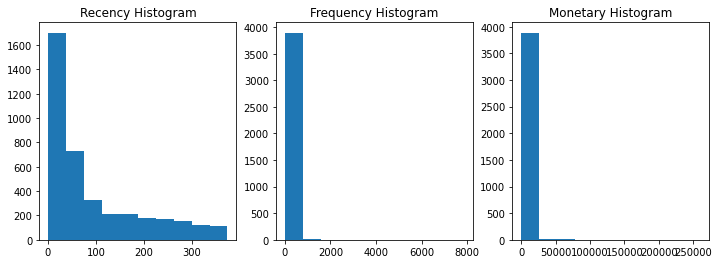

In [12]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

위 결과를 보면 예상한대로 특정 고객이 엄청나게 많이 주문했다.

Recency는 고객별로 자주 들어오는데 오른쪽을 보면 100일이 지나도 안들어오고 200, 300이 지나도 안들어오는 경우도 있다.

Freqeuncy를 보면 일부가 굉장히 자주 들어온다.

Monetary도 굉장히 큰 금액으로 주문하는 사람들이 일부있다.

In [13]:
cust_df[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


Recency : 중위값은 51인데 mean을 보면 92.74. 아무래도 오랫동안 안들어오는 사람들이 있다보니 평균값이 중위값보다 크다.<br>

Freqeuncy :  중위값이 41. max를 보면 7847, mean을 보면 75%(= 3/4 분위)에 가까울 정도로, 한방에 많은 Frequency를 내는 사람들 때문에 이렇게 분포도가 생기게 됨.<br>

Monetary: 중위는 654 인데 평균은 1864. 근데 맥스는 259657. 한방에 많은 사람들 때문에 평균값이 높은것.<br>

이러한 고객들이 있다는것에 유의를 하고 다음으로 넘어가자.

**K-Means로 군집화 후에 실루엣 계수 평가**

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency','Frequency','Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

실루엣 스코어는 : 0.592


실루엣 스코어가 0.592로 굉장히 좋은 수치가 나왔다. 

그런데 이게 잘 쪼개졌는지, 잘 군집화가되었는지, 잘 고객 세그맨테이션을 할 수 있는 기틀이 되는지 시각화로 확인해보자.

**K-Means 군집화 후에 실루엣 계수 및 군집을 시각화**

7-2 Cluster evaluation 때 썼던 함수임

각 클러스터 별로 실루엣 갯수가 어떻게 되어있는지 알 수 있었다.

그리고 클러스터별로 속하는 데이터 포인터들이 어디에 속하는 데이터가 얼마나 있는지와 실루엣 스코어의 분포를 볼 수 있는 그래프임

In [15]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성  
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [16]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

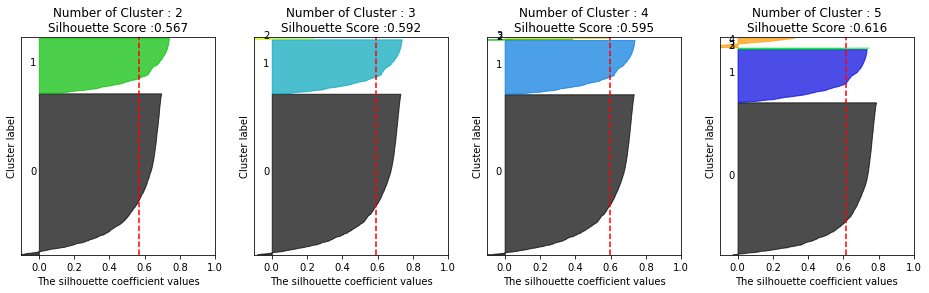

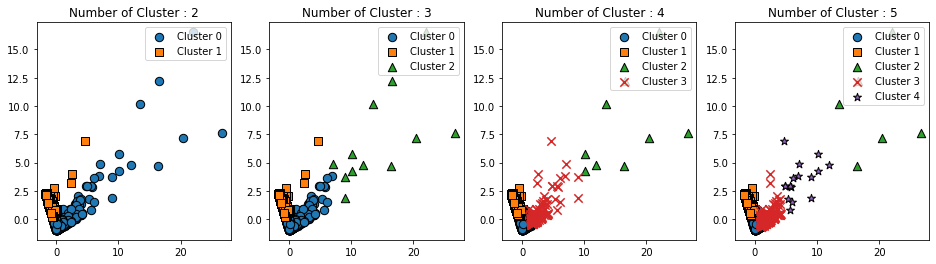

In [17]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

왼쪽에 촘촘한것들은 쪼개지 못하고 오른쪽에 것들만 계속 쪼개고 있다. 

그 이유는 거리기반으로 하기 떄문임. 그래서 로그 변환 후 다시 하는게 좋다. 좀더 정규분포에 가깝게 트랜스폼이 된다.

큰 값에 대한 영향력을 확 줄여야된다. 너무 큰 값들 때문에 오른쪽에 것들만 분할하고 있다.

**로그 변환 후 재 시각화**

In [18]:
### Log 변환을 통해 데이터 변환
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequecny, Monetary 컬럼에 np.log1p() 로 Log Transformation
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
X_features = cust_df[['Recency_log','Frequency_log','Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))


실루엣 스코어는 : 0.303


실루엣 스코어가 더 적어졌다. 클수록 좋다고 했는데, 사실 이 수치가 현실에 더 가깝다.

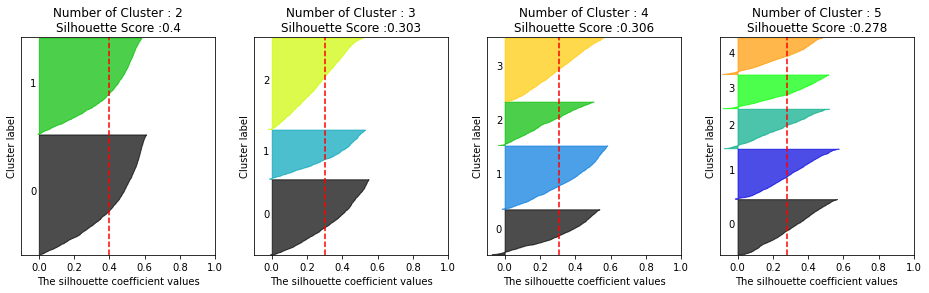

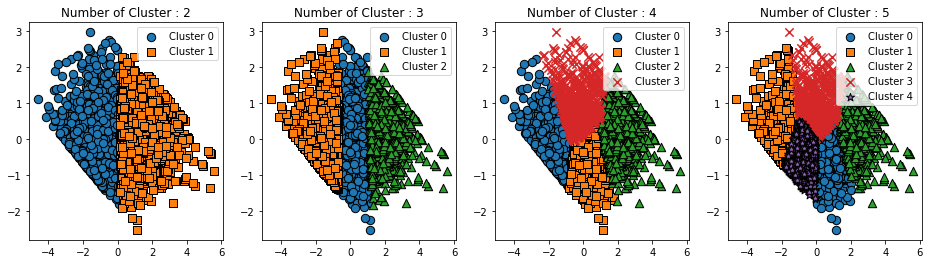

In [19]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

클러스터가 2개, 3개, 4개 일떄도 그렇고 각각 클러스터에 할당되는 고객들이 보다 균등하게 들어갔다. 

4로하나 3으로하나 실루엣 스코어가 그렇게 큰 차이가 없기 떄문에 4로 하는게 맞을 것 같다 이 상황에선.

5로해도 큰 문제는 없긴 할 것.

이렇게 균등하게 잘 분할이 되었다.